In [1]:
import keras
import pandas as pd
import numpy as np

In [2]:
identity = pd.read_csv("/content/train_identity.csv")
df = pd.read_csv("/content/train_transaction.csv")

In [3]:

import numpy as np
import warnings
warnings.filterwarnings('ignore')
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 1627.80 MB
Memory usage after optimization is: 434.33 MB
Decreased by 73.3%


In [4]:
train = pd.merge(df, identity, on='TransactionID', how='left')
del df
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_to_drop = list(set(many_null_cols  + big_top_value_cols  + one_value_cols))
cols_to_drop.remove('isFraud')
len(cols_to_drop)
train = train.drop(cols_to_drop, axis=1)

There are 414 columns in train dataset with missing values.


In [5]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
train_data = train

In [27]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 10
batch_size = 256

In [8]:
tf.autograph.set_verbosity(0)

In [9]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [10]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [11]:
def create_ffn(hidden_units,dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_columns = train_data.select_dtypes(['category']).columns
for i in cat_columns:
  train_data[i] = train_data[i].astype(str)
object_columns = train_data.select_dtypes(['object']).columns
for i in object_columns:
  train_data[i] = train_data[i].astype(str)
  train_data[i] = le.fit_transform(train_data[i])

In [13]:
train_data.fillna(0, inplace = True)
X = train_data.drop(["TransactionID", "isFraud"],1)
y = train_data.isFraud.astype("category")

In [14]:
feature_names = X.columns
num_features = len(X)
num_classes = 2

# Create target as a numpy array.
x_train = X.to_numpy()

# Create target as a numpy array.
y_train = y.to_numpy()


In [15]:
edges = train_data[["TransactionID", "isFraud"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    train_data.sort_values("TransactionDT")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 541520)
Nodes shape: (541520, 366)


In [16]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [24]:
def model_(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(366,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="model")


In [18]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages
      
   

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([aggregated_messages.T, node_repesentations.T], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations.astype(np.int32), neighbour_indices.astype(np.int32))
        neighbour_repesentations = neighbour_repesentations.astype(np.float)
        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)
        

In [19]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x[:32,]
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [20]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [29]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="model_",  # NAME OF OUR MODEL
)
print("GNN output shape:", gnn_model([1, 10]))
print(gnn_model.summary())
gnn_model = model_(hidden_units = hidden_units, dropout_rate = 0.23, num_classes = num_classes) # changed the dropoutrate

GNN output shape: tf.Tensor(
[[-1529.3611    212.20563]
 [-3985.8591   -666.5995 ]], shape=(2, 2), dtype=float32)
Model: "model_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (541520, 32)              14392     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 146525024 
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 127031456 
 )                                                               
                                                                 
 postprocess (Sequential)    (32, 32)                  2368      
                                                                 
 logits (Dense)              multiple                  66        
            

In [28]:
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/10
1799/1799 [==============================] - 35s 16ms/step - loss: 0.1095 - acc: 0.9707 - val_loss: 0.1057 - val_acc: 0.9732
Epoch 2/10
1799/1799 [==============================] - 28s 16ms/step - loss: 0.1065 - acc: 0.9714 - val_loss: 0.1050 - val_acc: 0.9721
Epoch 3/10
1799/1799 [==============================] - 29s 16ms/step - loss: 0.1056 - acc: 0.9715 - val_loss: 0.1088 - val_acc: 0.9731
Epoch 4/10
1799/1799 [==============================] - 30s 17ms/step - loss: 0.1049 - acc: 0.9717 - val_loss: 0.1082 - val_acc: 0.9714
Epoch 5/10
1799/1799 [==============================] - 29s 16ms/step - loss: 0.1040 - acc: 0.9719 - val_loss: 0.1099 - val_acc: 0.9695
Epoch 6/10
1799/1799 [==============================] - 28s 16ms/step - loss: 0.1031 - acc: 0.9722 - val_loss: 0.1140 - val_acc: 0.9697
Epoch 7/10
1799/1799 [==============================] - 29s 16ms/step - loss: 0.1031 - acc: 0.9724 - val_loss: 0.1128 - val_acc: 0.9713
Epoch 8/10
1799/1799 [==========================

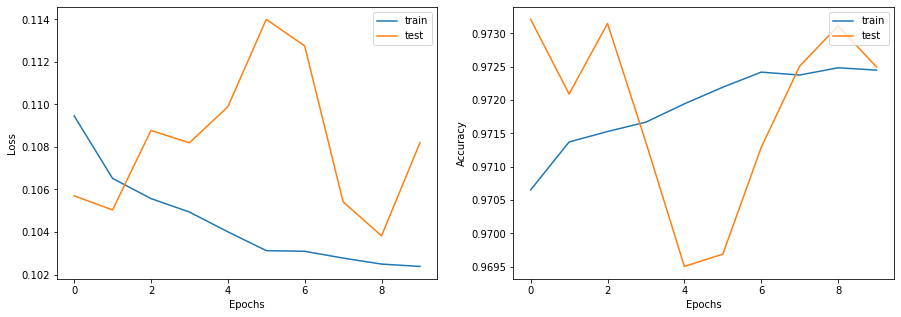

In [30]:
display_learning_curves(history)